In [1]:
from pyspark.sql import SparkSession, functions as F

# Khởi tạo SparkSession
spark = SparkSession.builder.appName("BigDataProject_Nhom14").getOrCreate()

# Đọc dữ liệu từ HDFS (hoặc local)
df = spark.read.option("header", "true").option("inferSchema", "true") \
    .csv("hdfs://localhost:9000/doannhom14/mobile_ai_app_usage.csv")

# Tiền xử lý
df_clean = df.dropna()
df_clean = df_clean.filter(
    (F.col("age") >= 13) & (F.col("age") <= 60) &
    (F.col("usage_minute") >= 1) & (F.col("usage_minute") <= 120)
)
df_clean = df_clean.withColumn("user_rating", F.col("user_rating").cast("double"))
df_clean = df_clean.withColumn("usage_minute", F.col("usage_minute").cast("double"))
df_clean = df_clean.withColumn("age", F.col("age").cast("integer"))

# Tổng hợp đặc trưng theo user_id
user_features = df_clean.groupBy("user_id").agg(
    F.avg("usage_minute").alias("avg_minute"),
    F.avg("user_rating").alias("avg_rating"),
    F.sum(F.when(F.col("payment_type") == "Premium", 1).otherwise(0)).alias("n_premium"),
    F.countDistinct("app_name").alias("num_app_used")
)
user_features.show(5)


+--------+----------+----------+---------+------------+
| user_id|avg_minute|avg_rating|n_premium|num_app_used|
+--------+----------+----------+---------+------------+
|U_109015|      56.0|       3.3|        0|           1|
|U_490124|      51.0|       1.9|        0|           1|
|U_901115|      51.0|       4.9|        1|           1|
|U_638575|      33.0|       4.3|        1|           1|
|U_518648|      85.0|       1.3|        0|           1|
+--------+----------+----------+---------+------------+
only showing top 5 rows



In [2]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Tạo vector đặc trưng
assembler = VectorAssembler(
    inputCols=["avg_minute", "avg_rating", "n_premium", "num_app_used"],
    outputCol="features_raw"
)
user_vec = assembler.transform(user_features)

# Chuẩn hóa
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(user_vec)
user_vec_scaled = scaler_model.transform(user_vec)

# Phân cụm KMeans
kmeans = KMeans(k=3, seed=42, featuresCol="features")
kmeans_model = kmeans.fit(user_vec_scaled)
predictions = kmeans_model.transform(user_vec_scaled)

# Đánh giá silhouette score
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette:.4f}")

# In trung tâm từng cụm
for i, center in enumerate(kmeans_model.clusterCenters()):
    print(f"Centroid {i}: {center}")

# Thống kê từng cụm
predictions.groupBy("prediction").agg(
    F.count("user_id").alias("num_users"),
    F.avg("avg_minute").alias("avg_minute"),
    F.avg("avg_rating").alias("avg_rating"),
    F.avg("n_premium").alias("avg_premium"),
    F.avg("num_app_used").alias("avg_app_used")
).show()


Silhouette Score: 0.2609
Centroid 0: [-0.02574392 -0.97693995  0.16005342  0.34776097]
Centroid 1: [ 0.95271468  0.56195212 -0.09050494 -0.20182356]
Centroid 2: [-0.93819598  0.57785182 -0.09625652 -0.2038825 ]
+----------+---------+-----------------+------------------+-------------------+------------------+
|prediction|num_users|       avg_minute|        avg_rating|        avg_premium|      avg_app_used|
+----------+---------+-----------------+------------------+-------------------+------------------+
|         1|    30212|93.00063440575488|3.6368236682996056| 0.1721501390176089|1.0046008208658812|
|         2|    29669|28.18628871886481|3.6572044895345606|0.16960463783747345|1.0041457413461863|
|         0|    34874|59.41111095180745|1.8874603333906532|0.27593622756208064|1.1282904169295176|
+----------+---------+-----------------+------------------+-------------------+------------------+



In [3]:
# Tạo nhãn: label = 1 nếu từng Premium, 0 nếu không
user_label = user_features.withColumn("label", F.when(F.col("n_premium") > 0, 1).otherwise(0))

assembler_lr = VectorAssembler(
    inputCols=["avg_minute", "avg_rating", "num_app_used"],
    outputCol="features"
)
data_lr = assembler_lr.transform(user_label).select("features", "label")


In [4]:
from pyspark.ml.feature import VectorAssembler

assembler_lr = VectorAssembler(
    inputCols=["avg_minute", "avg_rating", "num_app_used"],
    outputCol="features"
)
data_lr = assembler_lr.transform(user_label).select("features", "label")

# Hiển thị thử 5 dòng đầu
data_lr.show(5, truncate=False)


+--------------+-----+
|features      |label|
+--------------+-----+
|[56.0,3.3,1.0]|0    |
|[51.0,1.9,1.0]|0    |
|[51.0,4.9,1.0]|1    |
|[33.0,4.3,1.0]|1    |
|[85.0,1.3,1.0]|0    |
+--------------+-----+
only showing top 5 rows



In [5]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

train_lr, test_lr = data_lr.randomSplit([0.7, 0.3], seed=42)
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_lr)
predictions_lr = lr_model.transform(test_lr)

evaluator = BinaryClassificationEvaluator(labelCol="label")
auc = evaluator.evaluate(predictions_lr)
print(f"AUC (chưa cân bằng): {auc:.4f}")

accuracy = predictions_lr.filter(predictions_lr.label == predictions_lr.prediction).count() / predictions_lr.count()
print(f"Accuracy: {accuracy:.2%}")

# Confusion matrix
predictions_lr.groupBy("label", "prediction").count().show()


AUC (chưa cân bằng): 0.5192
Accuracy: 79.17%
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 5914|
|    0|       0.0|22554|
|    1|       1.0|   14|
|    0|       1.0|   24|
+-----+----------+-----+



In [6]:
# Đếm số lượng user theo nhãn
count_label = user_label.groupBy("label").count().toPandas()
majority = int(count_label[count_label.label == 0]["count"].iloc[0])
minority = int(count_label[count_label.label == 1]["count"].iloc[0])
ratio = majority / minority

# Thêm cột trọng số cho label thiểu số
user_label_w = user_label.withColumn(
    "classWeightCol",
    F.when(F.col("label") == 1, ratio).otherwise(1.0)
)
data_lr_w = assembler_lr.transform(user_label_w).select("features", "label", "classWeightCol")
train_lr_w, test_lr_w = data_lr_w.randomSplit([0.7, 0.3], seed=42)

lr_w = LogisticRegression(featuresCol="features", labelCol="label", weightCol="classWeightCol")
lr_model_w = lr_w.fit(train_lr_w)
predictions_lr_w = lr_model_w.transform(test_lr_w)

auc_w = evaluator.evaluate(predictions_lr_w)
print(f"AUC (có trọng số): {auc_w:.4f}")

accuracy_w = predictions_lr_w.filter(predictions_lr_w.label == predictions_lr_w.prediction).count() / predictions_lr_w.count()
print(f"Accuracy (có trọng số): {accuracy_w:.2%}")

# Confusion matrix
predictions_lr_w.groupBy("label", "prediction").count().show()


AUC (có trọng số): 0.5188
Accuracy (có trọng số): 78.01%
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 5341|
|    0|       0.0|21524|
|    1|       1.0|  500|
|    0|       1.0|  869|
+-----+----------+-----+



In [7]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)
rf_model = rf.fit(train_lr)         # <-- chỉ truyền train_lr
predictions_rf = rf_model.transform(test_lr)

auc_rf = evaluator.evaluate(predictions_rf)
print(f"AUC (Random Forest): {auc_rf:.4f}")

accuracy_rf = predictions_rf.filter(predictions_rf.label == predictions_rf.prediction).count() / predictions_rf.count()
print(f"Accuracy (Random Forest): {accuracy_rf:.2%}")

# Confusion matrix
predictions_rf.groupBy("label", "prediction").count().show()


AUC (Random Forest): 0.5250
Accuracy (Random Forest): 79.16%
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 5923|
|    0|       0.0|22560|
|    1|       1.0|    5|
|    0|       1.0|   18|
+-----+----------+-----+



In [8]:
TP = predictions_rf.filter((F.col("label") == 1) & (F.col("prediction") == 1)).count()
FP = predictions_rf.filter((F.col("label") == 0) & (F.col("prediction") == 1)).count()
TN = predictions_rf.filter((F.col("label") == 0) & (F.col("prediction") == 0)).count()
FN = predictions_rf.filter((F.col("label") == 1) & (F.col("prediction") == 0)).count()

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision (Premium): {precision:.4f}")
print(f"Recall (Premium): {recall:.4f}")
print(f"F1-score (Premium): {f1:.4f}")


Precision (Premium): 0.2174
Recall (Premium): 0.0008
F1-score (Premium): 0.0017


In [9]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Huấn luyện trên cùng dữ liệu như Logistic Regression (đã cân bằng)
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)
rf_model = rf.fit(train_lr_w)  # train_lr_w là tập train có trọng số như LR đã cân bằng (có thể dùng train_lr nếu muốn so sánh "nguyên bản")

# Dự đoán
predictions_rf = rf_model.transform(test_lr_w)

# Đánh giá chỉ số AUC, Accuracy
evaluator = BinaryClassificationEvaluator(labelCol="label")
auc_rf = evaluator.evaluate(predictions_rf)
accuracy_rf = predictions_rf.filter(predictions_rf.label == predictions_rf.prediction).count() / predictions_rf.count()

print(f"AUC (Random Forest): {auc_rf:.4f}")
print(f"Accuracy (Random Forest): {accuracy_rf:.2%}")

print("Confusion Matrix (Random Forest):")
predictions_rf.groupBy("label", "prediction").count().show()

# Precision/Recall/F1 nếu muốn nhấn mạnh về khả năng nhận diện Premium
TP = predictions_rf.filter((F.col("label") == 1) & (F.col("prediction") == 1)).count()
FP = predictions_rf.filter((F.col("label") == 0) & (F.col("prediction") == 1)).count()
FN = predictions_rf.filter((F.col("label") == 1) & (F.col("prediction") == 0)).count()

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
print(f"Precision (Premium): {precision:.4f}")
print(f"Recall (Premium): {recall:.4f}")


AUC (Random Forest): 0.5235
Accuracy (Random Forest): 79.32%
Confusion Matrix (Random Forest):
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 5835|
|    0|       0.0|22389|
|    1|       1.0|    6|
|    0|       1.0|    4|
+-----+----------+-----+

Precision (Premium): 0.6000
Recall (Premium): 0.0010


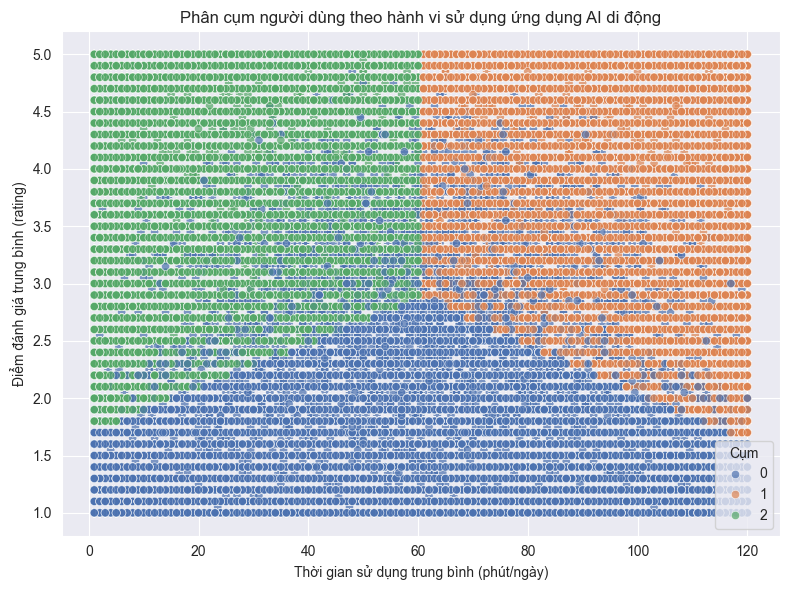

In [14]:
# Nếu cần, hãy import pandas và seaborn
import pandas as pd

# Xuất kết quả về Pandas DataFrame (chỉ lấy 2 đặc trưng và cột 'prediction' - cụm)
pdf = predictions.select("avg_minute", "avg_rating", "prediction").toPandas()
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pdf,
    x="avg_minute", y="avg_rating",
    hue="prediction", palette="deep", alpha=0.7
)
plt.title("Phân cụm người dùng theo hành vi sử dụng ứng dụng AI di động")
plt.xlabel("Thời gian sử dụng trung bình (phút/ngày)")
plt.ylabel("Điểm đánh giá trung bình (rating)")
plt.legend(title="Cụm")
plt.grid(True)
plt.tight_layout()
plt.show()


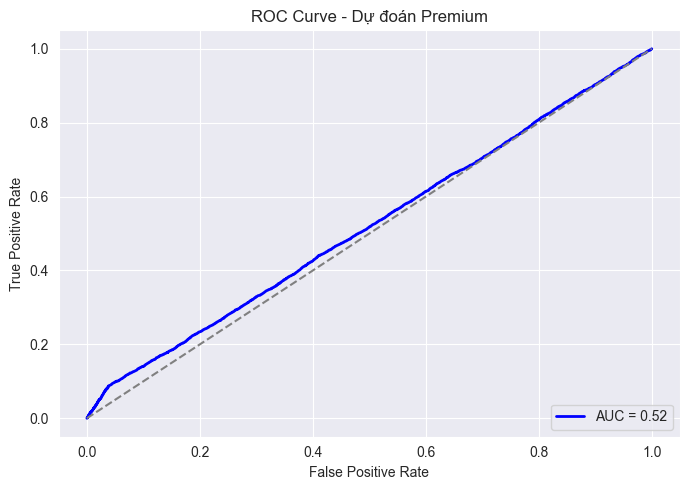

In [13]:
# Nếu cần, hãy import pandas và seaborn
import pandas as pd

# Xuất kết quả về Pandas DataFrame (chỉ lấy 2 đặc trưng và cột 'prediction' - cụm)
pdf = predictions.select("avg_minute", "avg_rating", "prediction").toPandas()


def get_prob(v): return float(v[1])  # lấy xác suất dự đoán Premium


pdf_lr = predictions_lr.select("label", "probability").toPandas()
pdf_lr["prob_premium"] = pdf_lr["probability"].apply(get_prob)
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(pdf_lr['label'], pdf_lr['prob_premium'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Dự đoán Premium')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
